In [2]:
# Interactive Figure
# %matplotlib ipympl 
# Non interactive
%matplotlib inline 

In [3]:
import time
import numpy as np
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qm import QuantumMachinesManager
from qm import SimulationConfig
from qualang_tools.results import fetching_tool
from qualang_tools.loops import from_array
import config_00 as config
import warnings
warnings.filterwarnings("ignore")
msg=np.load("msg_1007.npz")
msgI=msg["x"]
msgQ=msg["y"]

2025-05-21 17:42:16,464 - qm - INFO     - Starting session: 4729d304-7e2b-44de-9111-83dab7253f4f


In [4]:
def addjob(qmprog, qm):
    # Add a QUA program to the OPX queue, which compiles it and executes it
    job = qm.queue.add(qmprog)
    # Wait for job to be loaded
    while job.status=="loading":
        print("Job is loading...")
        time.sleep(0.1)
    # Wait until job is running
    time.sleep(0.1)
    while job.status=="pending":
        q = job.position_in_queue()
        if q>0:
            print("Position in queue",q,end='\r')
        time.sleep(0.1)
    job=job.wait_for_execution()
    print("\nJob is running")
    return job

In [5]:
# Connect to the cluster (run only once)
import QM_cluster
qmm = QuantumMachinesManager(host=QM_cluster.QM_Router_IP, cluster_name=QM_cluster.cluster_name)

2025-05-21 17:42:19,437 - qm - INFO     - Performing health check
2025-05-21 17:42:19,444 - qm - INFO     - Health check passed


# Connexion à la Quantum Machine

In [6]:
# Get the QM reference (rerun every time the config is changed)
qm_list =  qmm.list_open_qms()
qm = qmm.get_qm(qm_list[0])
print(f"Connected to {qm.id}")

Connected to qm-1690923308910


# Send Pulses and Demodulate them

In [10]:
n_points = 2048
with program() as prog:
    i = declare(int)
    n = declare(int)
    m = declare(int)
    I1 = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q1 = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I1_st = declare_stream()  # Stream for the 'I' quadrature
    Q1_st = declare_stream()  # Stream for the 'Q' quadrature
    I2 = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q2 = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I2_st = declare_stream()  # Stream for the 'I' quadrature
    Q2_st = declare_stream()  # Stream for the 'Q' quadrature

    with for_(n, 0, n < n_points, n + 1):
        # Play a weak pulse
        play("pulse"*amp(0.01), "qubit")
        # Demodulate the signals to get the 'I' & 'Q' quadratures)
        measure(
            "short_readout",
            "scope",
            dual_demod.full("cos", "sin", I1),
            dual_demod.full("minus_sin", "cos", Q1),
        )
        align()
        # Play a second puilse rotated in the IQ plane
        frame_rotation_2pi(0.05, "qubit")
        play("pulse"*amp(0.01), "qubit")
        measure(
            "short_readout",
            "scope",
            dual_demod.full("cos", "sin", I2),
            dual_demod.full("minus_sin", "cos", Q2),
        )        
        # Save the 'I' & 'Q' quadratures to their respective streams
        save(I1, I1_st)
        save(Q1, Q1_st)
        save(I2, I2_st)
        save(Q2, Q2_st)

    with stream_processing():
        # Cast the data into a 1D vector, and store the results on the OPX processor
        I1_st.buffer(n_points).save("I1")
        Q1_st.buffer(n_points).save("Q1")
        I2_st.buffer(n_points).save("I2")
        Q2_st.buffer(n_points).save("Q2")


In [11]:
# Run the code and fetch results
job = addjob(prog, qm)
res = fetching_tool(job, ['I1','Q1','I2','Q2'])
I, Q = res.fetch_all()
print('Job done')

2025-05-21 17:42:44,836 - qm - INFO     - Sending program to QOP for compilation

Job is running
Job done


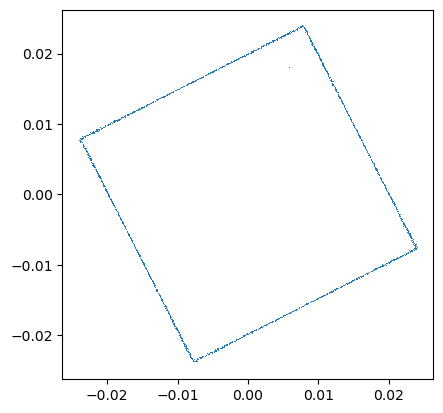

In [13]:
# Plot
fig,ax=plt.subplots()
ax.plot(I1,Q1,',')
ax.plot(I2,Q2,',')
ax.set_aspect('equal')

# Exercices

## Exercice 1: Histogrammes 
- Tourner les données dans le plan IQ pour que la différence entre les deux jeux de données soit codée sur une seule quadrature
- Tracer les histogrammes de la quadrature trouvée précédemment
 
## Exercise 2: Erreur de lecture
- Estimer la probabilité d'assigner un point expérimental au mauvais jeu de données
- Trouver expérimentalement l'angle de rotation minimal à mettre entre les jeux de données pour obtenir une erreur de lecture inférieure à 5%